# Projet : Série Chronologique

Importation des modules

In [147]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')


# On importe quelques outils pour les SARIMA, ACF/PACF, tests usuels, ...
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller

Importation des données

In [118]:
# dossier = '/users/2023/ds2/118003905/M2_serie_chrono/'
dossier = 'data/'
fichier = 'export_nb_par_semaine.csv'
#fichier = 'export_fr_par_jour.csv'

# On va travailler sur le jeu de données suivantes
Data = pd.read_csv(dossier+fichier)

# On enlève les premières dernières semaines qui représentent des semaines non entières.
Data = Data.iloc[2:-2]

# On renome les colonnes :
Data.columns = ['week', 'nb_vues']

# Séparons les dates, des valeurs :
Data_dates = Data['week']
Data_values = Data['nb_vues']

# 5 premières données :
print(Data.head(5))
n = len(Data_values)
print(n)

         week  nb_vues
2  2020-08-15     1395
3  2020-08-22     1428
4  2020-08-29      473
5  2020-09-01     1459
6  2020-09-08     1409
135


Testons immédiatement la stationnarité :

In [146]:
TestA = adfuller(Data_values) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Data_values) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])


ADF p-val :  2.283068542607219e-05
KPSS p-val :  0.1


Les tests semblent indiqués une stationnarité, mais cela reste douteux (p-value KPSS proche de 10%), observons les données :

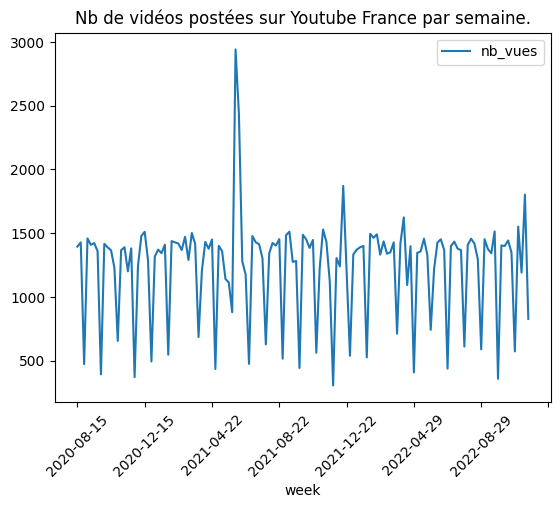

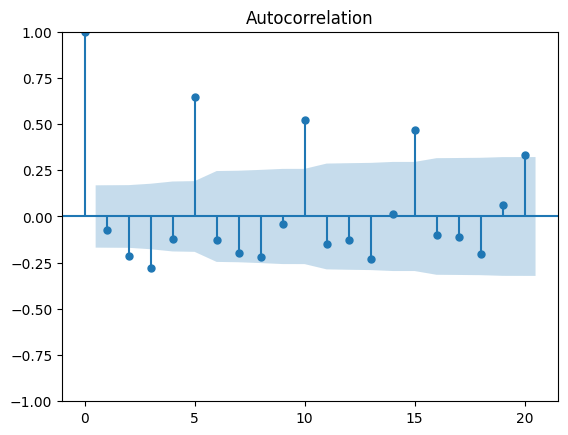

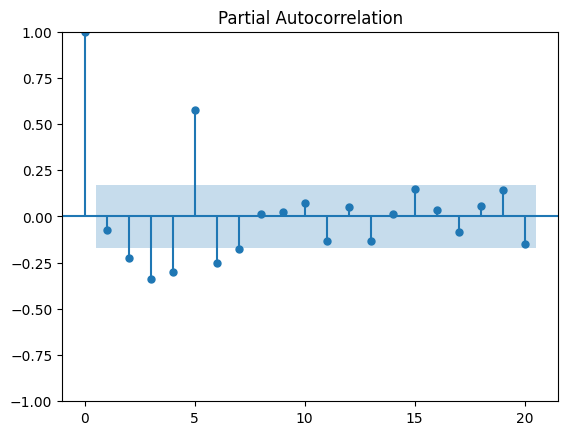

In [148]:
Data.plot(title = 'Nb de vidéos postées sur Youtube France par semaine.', x='week')
plt.xticks(rotation= 45)
plot_acf(Data_values, lags=20, alpha=0.05)
plot_pacf(Data_values, lags=20, alpha=0.05)
plt.show()

On observe clairement une périodicité de période 5, la série n'est pas stationnaire.

Appliquons une décomposition pour extraire les tendances linéaires et périodiques :

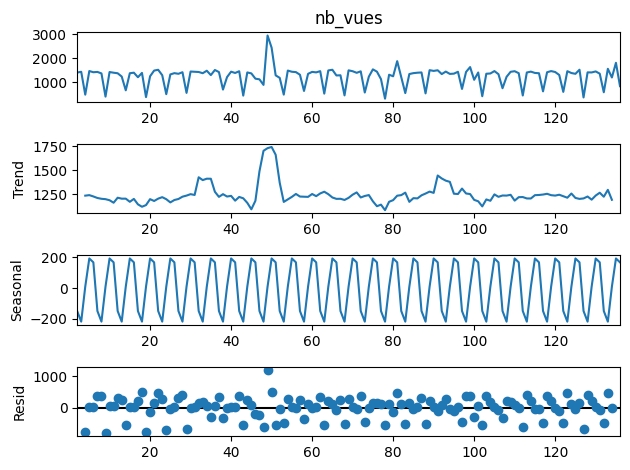

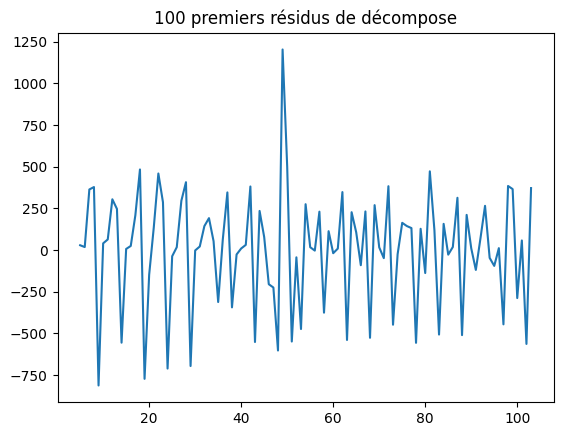

ADF p-val :  1.291442472591275e-07
KPSS p-val :  0.09680710797781689


In [149]:
# Décomposition 
Decomp = sm.tsa.seasonal_decompose(Data_values, model='additive', period = 5)
Decomp.plot()
plt.show()

# Regardons les rédidus
residus = Decomp.resid.dropna()
residus[1:100].plot()
plt.title('100 premiers résidus de décompose')
plt.show()

# Testons la stationnarité après désaisonnalisation (sur les résidus)
TestA = adfuller(residus) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(residus) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])


Choississons une transformation de Box-Cox :

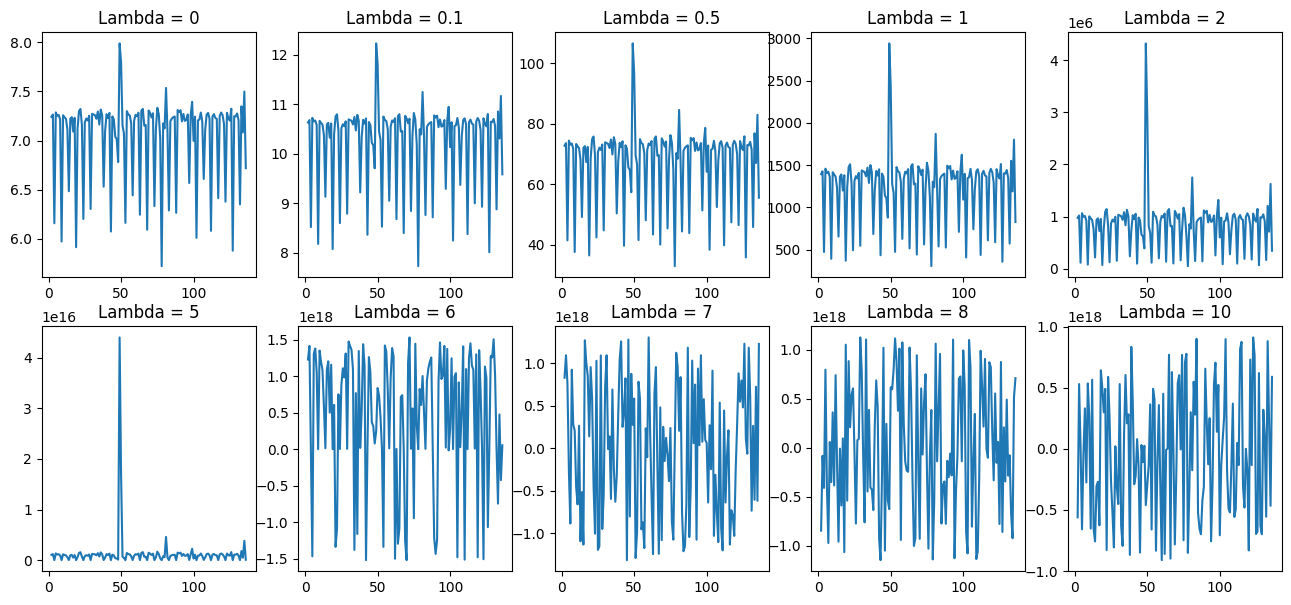

In [150]:
fig = plt.figure(figsize=(16,7))
axs = fig.subplots(2,5)

Liste_lambda = [0, 0.1, 0.5, 1, 2, 5, 6, 7, 8, 10]

for k, Lbda in enumerate(Liste_lambda):
    if Lbda == 0:
        transf = np.log(Data_values)
    else: transf = (Data_values**Lbda-1)/Lbda
    transf.plot(ax = axs[k//5,k%5], title = f'Lambda = {Lbda}')

Les valeurs de Lambda entre 6 et 10 paraissent intéressantes, mais les valeurs sont proches de 10**16, trop proches des limites de précision de la machine. On choisit une transformation pour lambda = 0, c'est à dire qu'on applique le log :

In [151]:
Ldata_values = np.log(Data_values)